In [21]:
from IFD_tsne import *
import numpy as onp
from jax import vjp, linearize, grad
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
from sklearn.datasets import make_spd_matrix, make_blobs
import matplotlib.pyplot as plt
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

In [3]:
def generate_data(n, p, random_state=0):
    '''
    Generates a dataset of n samples and p dimensions, such that it can be used to evaluate Monte-Carlo sampling
    vs. VIPurPCA. It is designed in a way, that the directions of the individual PCs are clear.
    
    Returns
    -------
        A : array
            Covariance over samples (NxN)
        B : array
            Covariance over features (PxP)
        X_flat : array
            Flattend mean matrix (NP)
        X_unflattener : fun
            Unflattens flattend mean back to matrix
    '''
    n, p = (n, p)
    X, y = make_blobs(n_samples=n, n_features=p, centers=10, random_state=random_state, shuffle=False, cluster_std=1)
    #key = jax.random.PRNGKey(42)
    #X = np.arange(1, p+1) * random.uniform(key, (n, p))
    y = None
    B = 0.1*make_spd_matrix(p)
    A = make_spd_matrix(n)
    X_flat, X_unflattener = flatten_util.ravel_pytree(X)
    return A, B, X_flat, X_unflattener, y

In [4]:
def draw_samples(key, X_flat, X_unflattener, A, B, n, p, n_iter):
    x = jax.random.normal(key, (p, n_iter, n))
    roll_rvs = np.tensordot(np.linalg.cholesky(B), np.dot(x, np.linalg.cholesky(A).T), 1)
    return  np.moveaxis(roll_rvs.T, 1, 0) + X_unflattener(X_flat)[np.newaxis, :, :]

def batches_mc(l, batch_size, n_iter):
    if n_iter==0:
        return l
    elif int(n_iter/batch_size)==0:
        l.append(n_iter)
        return l    
    else: 
        l.append(batch_size)
        return batches_mc(l, batch_size, n_iter-batch_size)

In [5]:
def MC(fun, mean_flat, mean_unflattener, A, B, n_iter, batch_size):
    '''
    Function for Monte-Carlo sampling. Samples from a given input distribution and applies PCA to each sample.
    
    Params
    -------
        mean_flat : array
            Flattend array to which PCA is applied
        mean_unflattener : fun
            Unflattens flattend mean back to matrix
        A : array
            Covariance over samples (NxN)
        B : array
            Covariance over features (PxP)
        p_keep : int
            Number of dimensions to keep
        n_iter : int
            Number of Monte-Carlo iterations
            
    Returns
    -------
        V : array (N_ITERxP_KEEPxP)
            Stacked arrays of Eigenvector Matrices    
    '''
    n, p = (A.shape[0], B.shape[0])
    key = jax.random.PRNGKey(42)
    b = batches_mc([], batch_size, n_iter)
    subkeys = jax.random.split(key, len(b))
    V = np.vstack([vmap(fun)(vmap(lambda x: np.ravel(x, 'F'))(draw_samples(i, mean_flat, mean_unflattener, A, B, n, p, j))) for i, j in zip(subkeys, b)])
    return V

In [ ]:
n, p = (50, 10)
batch_size=10
# input distribution
print('Generating samples')
A, B, X_flat, X_unflattener, y = generate_data(n, p)


# MC
print('Computing Monte-Carlo sampling')
n_iter = 100   # Monte-Carlo iterations

#X = onp.array(random.normal(key, shape=(50, 50)))
key = random.PRNGKey(42)
y_guess = random.normal(key, shape=(n, 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
tsne_fun = lambda x: tsne_fwd_for_MC(x, X_unflattener, y_guess)

# Draw n_iter samples from the input distribution and compute PCA on each sample
Vs, s = MC(tsne_fun, X_flat, X_unflattener, A, B, n_iter, batch_size)
print('Correct')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Generating samples
Computing Monte-Carlo sampling


In [7]:
n, p = (50, 10)
batch_size=10
# input distribution
print('Generating samples')
A, B, X_flat, X_unflattener, y = generate_data(n, p)


# MC
print('Computing Monte-Carlo sampling')
n_iter = 15   # Monte-Carlo iterations


key = jax.random.PRNGKey(42)
s = draw_samples(key, X_flat, X_unflattener, A, B, n, p, n_iter)


Generating samples
Computing Monte-Carlo sampling


In [8]:
Ys_MC = []
y_guess = random.normal(key, shape=(n, 2))

for i in s:
    Ys_MC.append(tsne_fwd(onp.array(i), y_guess))

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9541, 50 iterations in 0.6759 sec
Iteration  100, KL divergence 1.0204, 50 iterations in 0.6723 sec
Iteration  150, KL divergence 0.9716, 50 iterations in 0.6724 sec
Iteration  200, KL divergence 0.9781, 50 iterations in 0.6745 sec
Iteration  250, KL divergence 1.0092, 50 iterations in 0.6746 sec
   --> Time elapsed: 3.37 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.0428, 50 iterations in 0.6732 sec
Iteration  100, KL divergence 0.0302, 50 iterations in 0.6725 sec
Iteration  150, KL divergence 0.0302, 50 iterations in 0.6717 sec
Iteration  200, KL divergence 0.0302, 50 iterations in 0.6714 sec
Iteration 

In [43]:
print(onp.array(Ys_MC).shape)

(15, 50, 2)


/tmp/ipykernel_3091587/869587752.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Ys_MC[0][:, 0], Ys_MC[0][:, 1], c=y, cmap='tab10')
/tmp/ipykernel_3091587/869587752.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Ys_MC[10][:, 0], Ys_MC[10][:, 1], c=y, cmap='tab10')


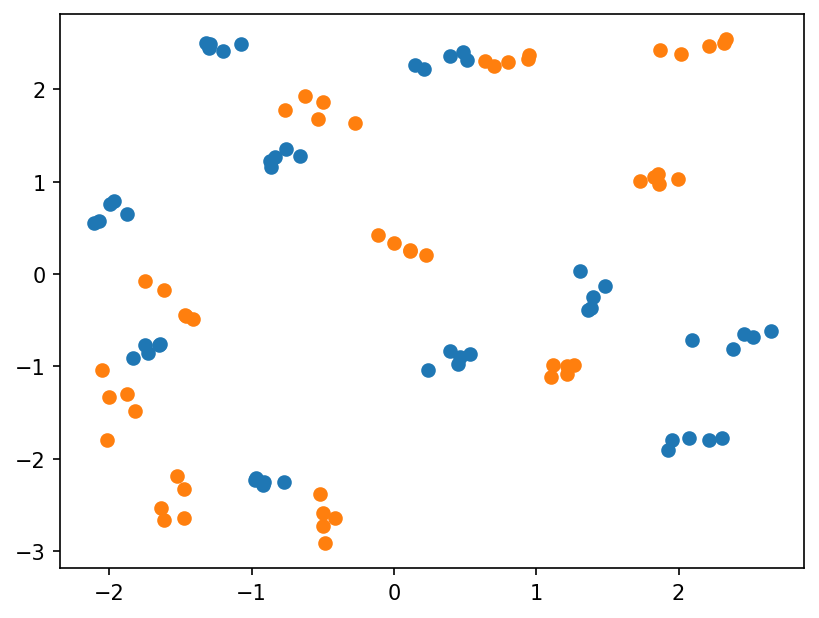

In [48]:
f = plt.figure()
plt.scatter(Ys_MC[0][:, 0], Ys_MC[0][:, 1], c=y, cmap='tab10')
plt.scatter(Ys_MC[10][:, 0], Ys_MC[10][:, 1], c=y, cmap='tab10')
#for i in Ys_MC:
#    plt.scatter(i[:, 0], i[:, 1], c=y, cmap='tab10')

In [17]:
Y_star = tsne_fwd(onp.array(X_unflattener(X_flat)), y_guess)
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9328, 50 iterations in 0.7172 sec
Iteration  100, KL divergence 0.9396, 50 iterations in 0.6777 sec
Iteration  150, KL divergence 0.9470, 50 iterations in 0.6695 sec
Iteration  200, KL divergence 0.9866, 50 iterations in 0.6668 sec
Iteration  250, KL divergence 1.0166, 50 iterations in 0.6669 sec
   --> Time elapsed: 3.40 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.0342, 50 iterations in 0.6679 sec
Iteration  100, KL divergence 0.0322, 50 iterations in 0.6680 sec
Iteration  150, KL divergence 0.0322, 50 iterations in 0.6691 sec
Iteration  200, KL divergence 0.0322, 50 iterations in 0.6672 sec
Iteration 

In [40]:
Y_star.shape

(50, 2)

In [18]:
def neumannApproximation(f_vjp, v, iterations):
    '''Neumann approximation of inverse-Hessian-vector product'''
    p = v
    for i in range(iterations):
        v -= f_vjp(v)[0]
        p += v
    return p

In [19]:
neumann_fun = lambda v: neumannApproximation(f_vjp, v, Y_flat, 200)

In [22]:
funY = lambda y: regularized_KL_divergence(X_flat, y, X_unflattener, Y_unflattener)
funX = lambda x: regularized_KL_divergence(x, Y_flat, X_unflattener, Y_unflattener)
funXY = partial(regularized_KL_divergence, X_unflattener=X_unflattener, Y_unflattener=Y_unflattener)
_, hessian_vjp = vjp(grad(funY), Y_flat)
neumann_fun = lambda v: neumannApproximation(hessian_vjp, v, 200)
Jx_fun = lambda x: jax.grad(funXY, argnums=1)(x, Y_flat)
_, Jacobian_vjp = vjp(Jx_fun, X_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [23]:
v_in = np.eye(len(X_flat))
Jx_fun2 = lambda y: jax.grad(funXY, argnums=0)(X_flat, y)
_, Jacobian_jvp = vjp(Jx_fun2, Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [24]:
Jx_fun2(Y_flat).shape

Computing pairwise distances...
Starting binary search
Entered binary search function


(500,)

In [25]:
def compute_cov(neumann_fun, Jacobian_vjp, Jacobian_jvp, A, B, i, N, D):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), 2*N))
    print(v1.shape)
    v2 = neumann_fun(v1)
    print(v2.shape)
    v3 = Jacobian_vjp(v2)[0]
    print(v3.shape)
    v4 = np.ravel(np.dot(np.dot(A, np.reshape(v3, (N, D), 'C')), np.transpose(B)), 'C')
    print(v4.shape)
    v5 = Jacobian_jvp(v4)[0]
    print(v5)
    v6 = neumann_fun(v5)
    return v6

In [27]:
N, D = X_unflattener(X_flat).shape


In [28]:
compute_cov_fun = lambda i: compute_cov(neumann_fun, Jacobian_vjp, Jacobian_jvp, A, B, i, N, D)
cov = vmap(compute_cov_fun)(np.array([i for i in range(2*N)]))

(100,)
(100,)
(500,)
(500,)
Traced<ShapedArray(float32[100])>with<BatchTrace(level=1/0)> with
  val = Array([[ 5.8809397e-05, -4.3654336e-06,  1.2219617e-05, ...,
        -4.8741940e-06,  6.0994353e-07,  1.5663436e-06],
       [-1.6666105e-05,  6.7691672e-06, -1.4204547e-06, ...,
         1.9222521e-06,  1.3994905e-07, -7.9885706e-07],
       [ 1.6769845e-05, -2.6217890e-08,  2.5643587e-05, ...,
        -2.1101127e-06, -1.9546223e-07,  7.1272416e-07],
       ...,
       [-2.7281869e-06,  1.2793024e-07, -9.4651716e-07, ...,
         5.8368951e-06, -9.1283800e-07,  3.9130930e-07],
       [ 3.9620386e-06, -2.2534005e-07,  9.4983682e-07, ...,
        -2.0200785e-06,  4.2466381e-06, -7.6044785e-08],
       [ 3.9474339e-06, -3.0696506e-07,  1.1462982e-06, ...,
         6.6733037e-08, -5.4107858e-08,  3.4915909e-06]], dtype=float32)
  batch_dim = 0


In [38]:
from utils import equipotential_standard_normal, animate_ifd
S = equipotential_standard_normal(2 * Y_star.shape[0], 20)
L, lower = jax.scipy.linalg.cho_factor(cov+1e-5*np.eye(len(cov)), lower=True)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_flat)
np.save('samples.npy', samples)
np.save('labels.npy', [i for i in range(50)])

In [41]:
print(samples.shape)

(100, 19)


In [35]:
print(y)

None


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


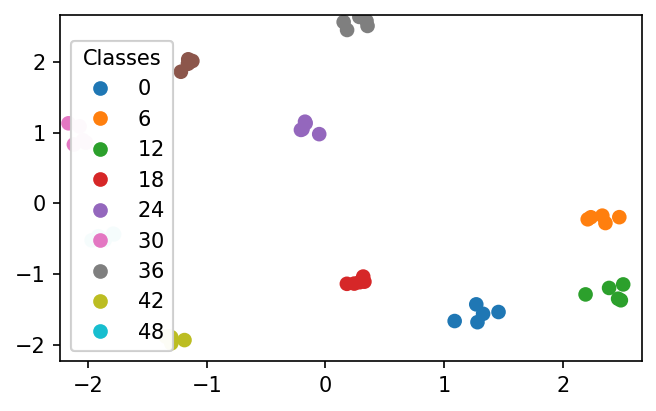

In [39]:
from utils import equipotential_standard_normal, animate_ifd
animate_ifd('samples.npy', 'labels.npy', 'animation.gif')